In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("seryouxblaster764/fgvc-aircraft")

print("Path to dataset files:", path)

100%|██████████| 2.57G/2.57G [00:31<00:00, 86.5MB/s]

Extracting files...


Path to dataset files: /home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2


In [1]:
import datetime
import tensorflow as tf
import keras
import tensorflow_datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

2025-02-04 22:58:00.425314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738727880.446830 1697316 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738727880.453425 1697316 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 22:58:00.474370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!ls /home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2

fgvc-aircraft-2013b  test.csv  train.csv  val.csv


In [3]:
train_pandas = pd.read_csv("/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/train.csv")
val_pandas = pd.read_csv("/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/val.csv")
test_pandas = pd.read_csv("/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/test.csv")

In [4]:
img_size = (299, 299)

def convert_image(img, label):
    img = tf.image.decode_jpeg(tf.io.read_file(img), channels=3)
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, img_size), label

def augment(img, label):
    return tf.image.random_flip_left_right(img), label

X_train = []
X_val = []
X_test = []

for img in train_pandas['filename']:
    X_train.append(f"/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/{img}")

for img in val_pandas['filename']:
    X_val.append(f"/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/{img}")

for img in test_pandas['filename']:
    X_test.append(f"/home/yue.r/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/{img}")

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_pandas['Labels'])).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE).map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, val_pandas['Labels'])).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, test_pandas['Labels'])).map(convert_image, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 16

train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(2048)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

I0000 00:00:1738727893.814251 1697316 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:82:00.0, compute capability: 6.0


In [10]:
from tensorflow.keras.applications import DenseNet201

model = DenseNet201(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

import keras

def mish(x):
    return x * K.tanh(Ac.softplus(x))

x = keras.layers.GlobalAveragePooling2D()(model.output)
x = keras.layers.Dense(1024, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(.5)(x)
x = keras.layers.Dense(512, activation='mish')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(.5)(x)
output = keras.layers.Dense(100, activation='softmax')(x)

In [11]:
model = keras.models.Model(inputs=model.input, outputs=output)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
log_dir = "logs/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
class TargetValAccCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, threshold_2):
        super(TargetValAccCallback, self).__init__()
        self.threshold = threshold
        self.threshold_2 = threshold_2

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs["val_sparse_categorical_accuracy"]
        train_acc = logs["sparse_categorical_accuracy"]
        if val_acc >= self.threshold and train_acc >= self.threshold_2:
            self.model.stop_training = True

early_stopping_callback = TargetValAccCallback(threshold=0.735, threshold_2=0)

n_steps = len(X_train) // batch_size

history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback],
)

Epoch 1/30


2025-02-04 23:14:40.163138: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_8', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_2', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_reduce_subtract_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_318', 8 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_321', 4 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_349', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in functi

208/208 ━━━━━━━━━━━━━━━━━━━━ 479s 547ms/step - loss: 5.7460 - sparse_categorical_accuracy: 0.0220 - val_loss: 3.9837 - val_sparse_categorical_accuracy: 0.1221
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 79s 380ms/step - loss: 4.1404 - sparse_categorical_accuracy: 0.1223 - val_loss: 2.8806 - val_sparse_categorical_accuracy: 0.2670
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 78s 373ms/step - loss: 2.9937 - sparse_categorical_accuracy: 0.2672 - val_loss: 2.1390 - val_sparse_categorical_accuracy: 0.4335
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 77s 372ms/step - loss: 2.2490 - sparse_categorical_accuracy: 0.4039 - val_loss: 1.7722 - val_sparse_categorical_accuracy: 0.5158
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 79s 380ms/step - loss: 1.6836 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.4342 - val_sparse_categorical_accuracy: 0.6043
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 79s 380ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.6460 - val_loss: 1.2933 - val_sparse_categorical_accuracy: 0.6

In [14]:
print("Evaluation on test data:")
results = model.evaluate(test_dataset, batch_size=128)

Evaluation on test data:
209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - loss: 1.2193 - sparse_categorical_accuracy: 0.6547


In [15]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_acc(history):
  plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

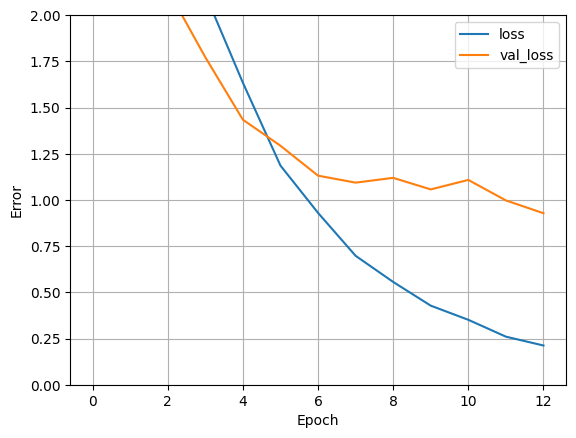

In [16]:
plot_loss(history)

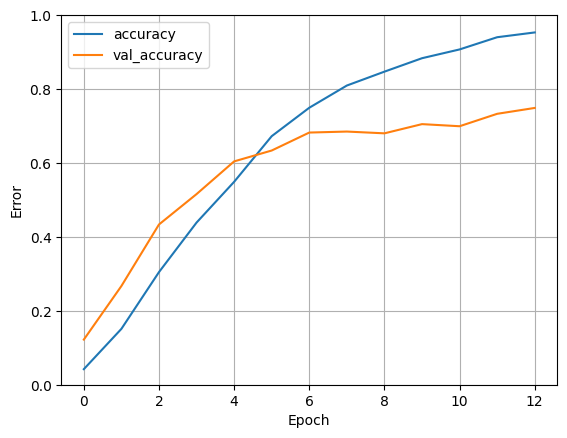

In [17]:
plot_acc(history)